In [2]:
%%capture
import warnings, sys
warnings.filterwarnings('ignore')
sys.stderr = open('/dev/null', 'w')



# Avoiding undesired imputation of certain missing data

To avoid imputing certain missing datapoints, construct a `imputable_matrix`(DNI matrix) of the same size and shape as the original dataset. For this matrix, use 1 to represent values in the original dataset that are either **missing and viable** for imputation or **non-missing**. Use 0 to represent values in the original dataset that are missing but **not viable** for imputation (for example, measurements at timepoints occuring after death). To use the `cols_ignore` argument in `run_cissvae` or `ClusterDataset()`, make sure that the `imputable_matrix` has the same column names/indices as the original dataset. 

## Example using included dataset

First load the dataset and load or create the DNI matrix. Here we can see that [1, Y12], [2, Y22], and [1, Y52] are marked as non-imputable. 


In [5]:
import pandas as pd
from ciss_vae.data import load_example_dataset, load_dni
import ciss_vae

df_missing, _, clusters = load_example_dataset()

dni = load_dni()

dni.columns = df_missing.columns

print(f"Df missing:\n{df_missing.head(3).drop(df_missing.columns[:5].to_list(), axis=1)}, \n\nImputable Matrix:\n{dni.head(3).drop(df_missing.columns[:5].to_list(), axis=1)}")

Df missing:
        Y11  Y12        Y13        Y14        Y15        Y21  Y22        Y23  \
0 -4.049537  NaN        NaN -14.369151 -17.564448        NaN  NaN -35.772630   
1  0.546168  NaN -12.189518  -7.722474        NaN  -7.470250  NaN -25.924360   
2       NaN  NaN -20.358905 -15.126494 -17.251376 -18.448422  NaN -34.400862   

         Y24        Y25  ...       Y41  Y42       Y43       Y44       Y45  \
0 -28.098906 -30.242588  ... -0.904960  NaN       NaN -3.694852 -5.680293   
1 -17.231424 -18.695290  ...  2.624586  NaN -5.776195 -1.379495 -2.329604   
2 -27.250598 -28.839809  ...       NaN  NaN -7.215718 -3.350797 -6.895340   

        Y51  Y52       Y53       Y54       Y55  
0  2.587588  NaN -4.681195 -2.248406 -2.679081  
1  6.080512  NaN -2.290062 -0.887398  0.562532  
2  2.531148  NaN -5.427430 -1.330163 -2.324382  

[3 rows x 25 columns], 

Imputable Matrix:
   Y11  Y12  Y13  Y14  Y15  Y21  Y22  Y23  Y24  Y25  ...  Y41  Y42  Y43  Y44  \
0    1    1    1    1    1    1    1  

## Using `run_cissvae()` with DNI matrix

The `run_cissvae()` function can accept the DNI matrix as an input. Make sure that the column names of the DNI matrix match those of the original dataset. 

In [6]:
from ciss_vae.training.run_cissvae import run_cissvae
from ciss_vae.utils.helpers import plot_vae_architecture

imputed_data, vae, ds, history = run_cissvae(data = df_missing,
## Dataset params
    columns_ignore = df_missing.columns[:5], ## columns to ignore when selecting validation dataset (and clustering if you do not provide clusters). For example, demographic columns with no missingness.
    imputable_matrix=dni,
    clusters = clusters,
    print_dataset = False,
    
## VAE model params
    hidden_dims = [150, 120, 60], ## Dimensions of hidden layers, in order. One number per layer. 
    latent_dim = 15, ## Dimensions of latent embedding
    layer_order_enc = ["unshared", "unshared", "unshared"], ## order of shared vs unshared layers for encode (can use u or s instead of unshared, shared)
    layer_order_dec=["shared", "shared",  "shared"],  ## order of shared vs unshared layers for decode
    latent_shared=False, 
    output_shared=False, 
    batch_size = 4000, ## batch size for data loader
    return_model = True, ## if true, outputs imputed dataset and model, otherwise just outputs imputed dataset. Set to true to return model for `plot_vae_architecture`

## Initial Training params
    epochs = 5, ## default 

## Other params
    return_history = True, ## if true, will return training MSE history as pandas dataframe
    return_dataset=True
)

print(f"The successfully imputed dataset:\n{imputed_data.head}\n\n")

The successfully imputed dataset:
<bound method NDFrame.head of             Age    Salary  ZipCode10001  ZipCode20002  ZipCode30003  \
0     11.044449  6.366204           0.0           1.0           0.0   
1      9.727260  5.912558           1.0           0.0           0.0   
2     11.383020  6.636472           0.0           1.0           0.0   
3     13.560905  5.896255           0.0           0.0           1.0   
4      9.542490  6.128326           1.0           0.0           0.0   
...         ...       ...           ...           ...           ...   
7995  15.557709  6.202669           1.0           0.0           0.0   
7996  10.675848  6.294101           1.0           0.0           0.0   
7997   8.461785  5.317789           0.0           0.0           1.0   
7998  13.917788  5.052571           0.0           0.0           1.0   
7999  15.152122  5.258686           1.0           0.0           0.0   

            Y11        Y12         Y13         Y14         Y15  ...       Y41  \
0 

In [ ]:
ds

Below, we can see that [1, Y12], [2, Y22], and [1, Y52] are still NaN, even though other missing entries have been imputed. 

In [7]:
print(f"Imputed dataset:\n{imputed_data.drop(df_missing.columns[:5].to_list(), axis=1).head(3)}")

Imputed dataset:
        Y11        Y12        Y13        Y14        Y15        Y21        Y22  \
0 -4.049537 -23.776985 -17.498016 -14.369148 -17.564449 -11.475680 -29.109577   
1  0.546168        NaN -12.189518  -7.722473 -11.081120  -7.470250 -33.593620   
2 -2.596828 -18.962170 -20.358906 -15.126495 -17.251385 -18.448421        NaN   

         Y23        Y24        Y25  ...       Y41       Y42       Y43  \
0 -35.772629 -28.098907 -30.242588  ... -0.904960 -7.386673 -6.179434   
1 -25.924362 -17.231422 -18.695286  ...  2.624586 -8.668818 -5.776196   
2 -34.400864 -27.250603 -28.839817  ... -0.597668 -4.789593 -7.215717   

        Y44       Y45       Y51       Y52       Y53       Y54       Y55  
0 -3.694853 -5.680294  2.587588 -7.472216 -4.681194 -2.248405 -2.679079  
1 -1.379498 -2.329605  6.080512       NaN -2.290062 -0.887398  0.562532  
2 -3.350798 -6.895340  2.531148 -3.592981 -5.427431 -1.330162 -2.324381  

[3 rows x 25 columns]


As always, the vae architecture can be printed. 

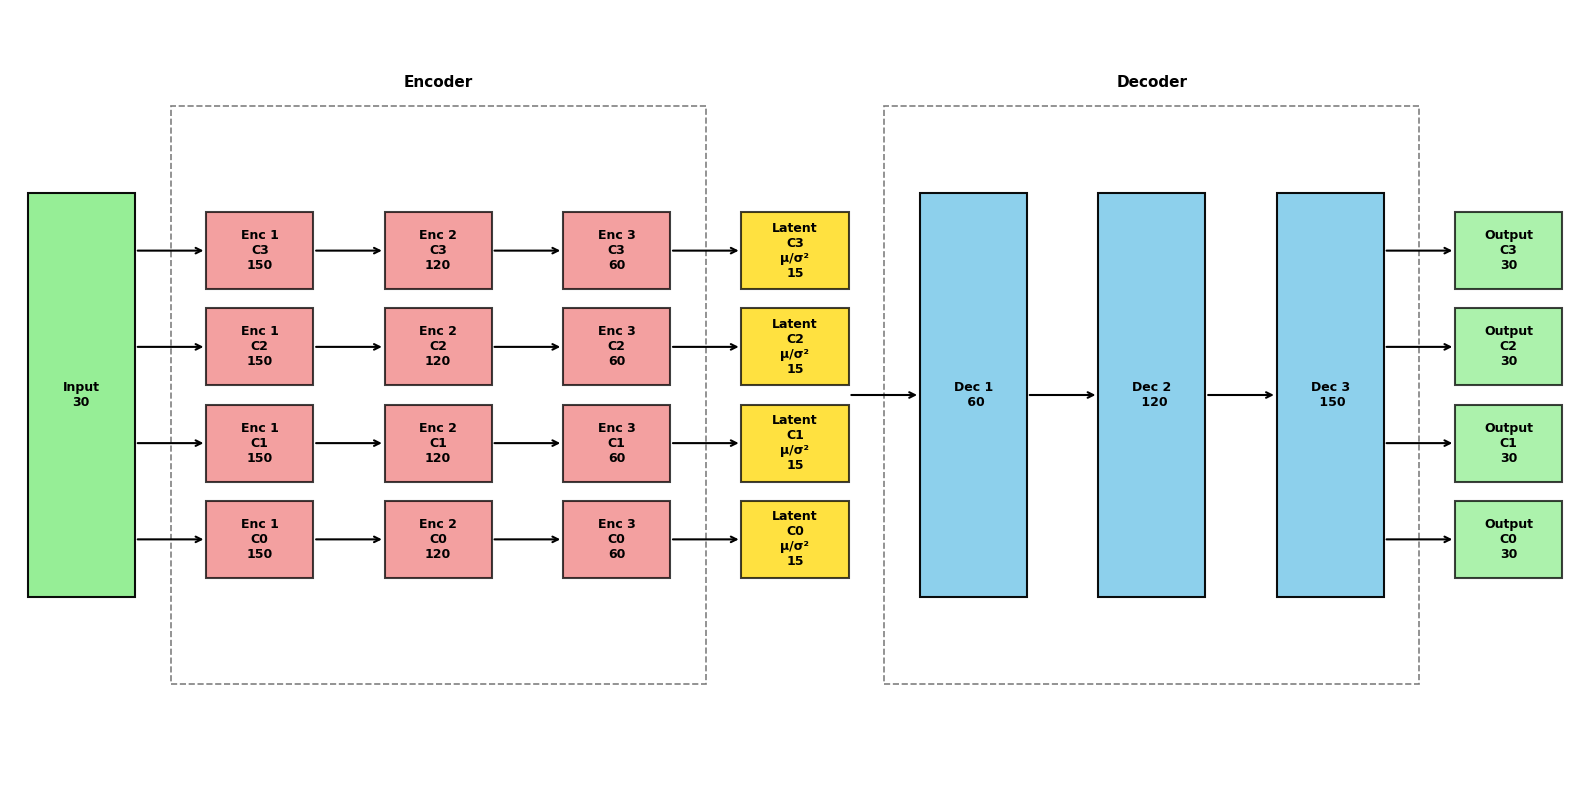

In [8]:
plot_vae_architecture(model = vae,
                        title = None, ## Set title of plot
                        ## Colors below are default
                        color_shared = "skyblue", 
                        color_unshared ="lightcoral",
                        color_latent = "gold", # xx fix
                        color_input = "lightgreen",
                        color_output = "lightgreen",
                        figsize=(16, 8),
                        return_fig = False)

## We can also use the imputable matrix with the autotune function. 

In [10]:
import pandas as pd
from ciss_vae.data import load_example_dataset, load_dni
from ciss_vae.classes.cluster_dataset import ClusterDataset
from ciss_vae.training.autotune import SearchSpace, autotune

df_missing, _, clusters = load_example_dataset()

dni = load_dni()

dataset = ClusterDataset(
    data = df_missing,
    cluster_labels = clusters,
    imputable = dni,

)

dataset


ClusterDataset(n_samples=8000, n_features=30, n_clusters=4)
  • Original missing: 61800 / 240000 (25.75%)
  • Validation held-out: 17783 (9.98% of non-missing)
  • .data shape:     (8000, 30)
  • .masks shape:    (8000, 30)
  • .val_data shape: (8000, 30)
  • Non-imputable entries: 6180

In [ ]:
searchspace = SearchSpace(
                 num_hidden_layers=(1, 4), ## Set number of hidden layers
                 hidden_dims=[64, 512], ## Allowable dimensions of hidden layers
                 latent_dim=[10, 100],
                 latent_shared=[True, False],
                 output_shared=[True,False],
                 lr=(1e-4, 1e-3),
                 decay_factor=(0.9, 0.999),
                 beta=0.01,
                 num_epochs=100,
                 batch_size=64,
                 num_shared_encode=[0, 1, 3],
                 num_shared_decode=[0, 1, 3],
                 encoder_shared_placement = ["at_end", "at_start", "alternating", "random"], ## where should the shared layers be placed in the encoder
                 decoder_shared_placement = ["at_end", "at_start", "alternating", "random"], ## where should the shared layers be placed in the decoder
                 refit_patience=2,
                 refit_loops=10,
                 epochs_per_loop = 100,
                 reset_lr_refit = [True, False])

results = autotune(
    search_space = searchspace,
    train_dataset = dataset,                   # ClusterDataset object
    save_model_path=None,
    save_search_space_path=None,
    n_trials=20,
    study_name="vae_autotune_v3",                 # Default study name
    device_preference="cuda",
    show_progress=True,                       # Show progress bar for training
    optuna_dashboard_db="sqlite:///test_dni_python.sqlite3",                  # If using optuna dashboard set db location here
    load_if_exists=True,                       # If using optuna dashboard, if study by 'study_name' already exists, will load that study
    seed = 42,     
)